In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from datetime import timedelta, date
from quantbullet.utils.data import generate_fake_bond_trades
from quantbullet.model_selection.rolling_window import RollingWindowManager, RollingWindowBacktester
from quantbullet.model import Model, Feature, FeatureSpec, FeatureRole, DataType

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Synthetic Data

Generate some synthetic data to test the model. Only Feature A and Feature B are relevant for the target variable. And for each rating, we have different distributions of Feature A and Feature B.

In [7]:
START_DATE = date( 2025, 1, 1 )
END_DATE = date( 2025, 4, 30 )

In [8]:
df = generate_fake_bond_trades( start_date=START_DATE, end_date=END_DATE, 
                                random_state=42, cluster_by_rating=True,
                                theo_coefficients=( 0.15, 0.25, 0, 0 ),
                                response_std=0.3)

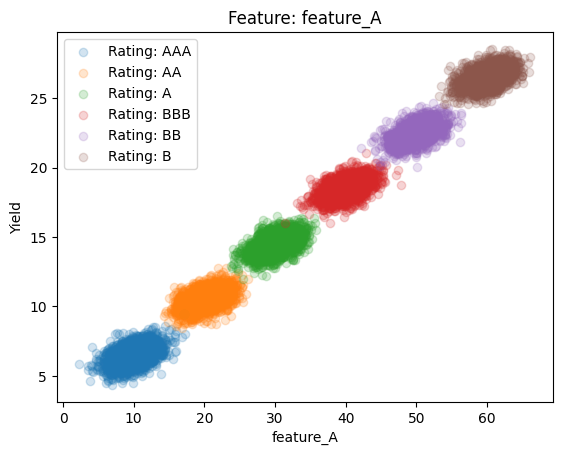

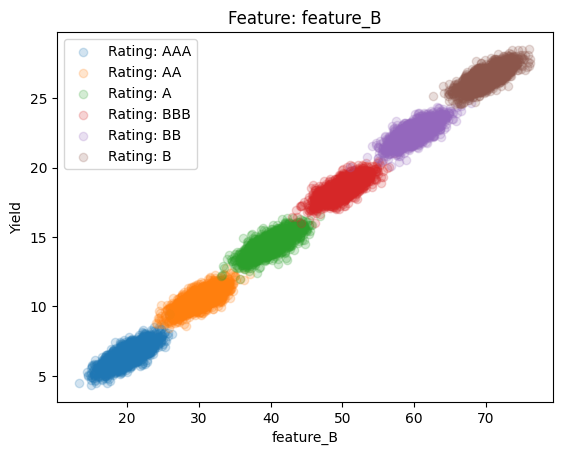

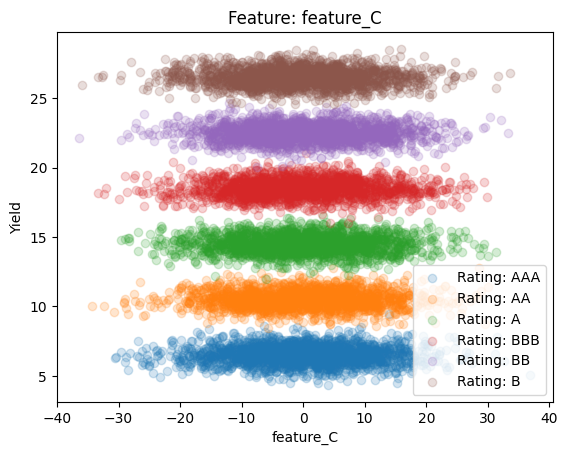

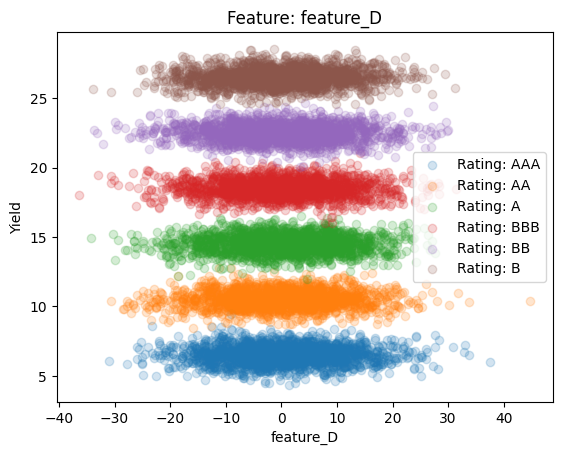

In [9]:
import matplotlib.pyplot as plt

for feat in ['feature_A', 'feature_B', 'feature_C', 'feature_D']:
    plt.figure()
    plt.title( f"Feature: {feat}" )
    plt.xlabel( feat )
    plt.ylabel( "Yield" )
    for rating in df['rating'].unique():
        plt.scatter(
            df[df['rating'] == rating][feat],
            df[df['rating'] == rating]['yield'],
            label=f'Rating: {rating}',
            alpha=0.2
        )
    plt.legend()
    plt.show()

## Dummy Model

The dummy model simply predicts the mean of each rating group to predict the next.

In [10]:
AverageYieldModelFeatureSpec = FeatureSpec(
    [
        Feature( "rating", DataType.CATEGORICAL, FeatureRole.MODEL_INPUT),
        Feature( "yield", DataType.FLOAT, FeatureRole.TARGET)
    ]
)

In [11]:
class AverageYieldModel( Model ):
    def __init__( self, feature_spec: FeatureSpec ):
        super().__init__( feature_spec )

    def fit( self, X, y=None ):
        self._rating_map = X.groupby( "rating" ).agg( { "yield": "mean" } ).reset_index()
        self._rating_map = self._rating_map.set_index( "rating" ).to_dict()

    def predict( self, X ):
        return X[ "rating" ].map( self._rating_map[ "yield" ] ).values

In [12]:
rwm = RollingWindowManager.from_flat( df, window_size=30 )
model = AverageYieldModel( feature_spec=AverageYieldModelFeatureSpec )
backtester = RollingWindowBacktester( rolling_window_manager=rwm, model=model )

In [13]:
backtester.run( use_multithreading=False )

In [14]:
avg_yield_model_backtest_res = backtester.get_logger_df()

In [15]:
mean_absolute_error( avg_yield_model_backtest_res[ "yield" ], avg_yield_model_backtest_res[ "loggerPred" ] )

0.5295939738684491

## KNN Model

We use a KNN model to find the nearest neighbors based on Feature A and Feature B, and then predict the target variable based on the mean of the neighbors' target values.

In [16]:
from quantbullet.model.neighbors import FeatureScaledKNNRegressor

In [17]:
knnModelFeatureSpec = FeatureSpec(
    [
        Feature( "rating", DataType.CATEGORICAL, FeatureRole.REFERENCE),
        Feature( "feature_A", DataType.FLOAT, FeatureRole.MODEL_INPUT),
        Feature( "feature_B", DataType.FLOAT, FeatureRole.MODEL_INPUT),
        Feature( "feature_C", DataType.FLOAT, FeatureRole.MODEL_INPUT),
        Feature( "feature_D", DataType.FLOAT, FeatureRole.MODEL_INPUT),
        Feature( "yield", DataType.FLOAT, FeatureRole.TARGET)
    ]
)

In [18]:
class KNNModel( Model ):
    def __init__( self, 
                 feature_spec: FeatureSpec,
                 n_neighbors: int = 5,
                 metrics: str = "euclidean",
                 weights: str = "uniform",
                 feature_weights: tuple | list | None = None ):
        super().__init__( feature_spec )
        self.knn_models_ = {}
        self.n_neighbors = n_neighbors
        self.metrics = metrics
        self.weights = weights
        self.feature_weights = feature_weights

    def fit( self, X, y=None ):
        # for each rating, we will create a KNN model
        for rating in X[ self.feature_spec.FEATURES.RATING ].unique():
            X_rating = X.loc[X[self.feature_spec.FEATURES.RATING] == rating, self.feature_spec.x]
            y_rating = X.loc[X[self.feature_spec.FEATURES.RATING] == rating, self.feature_spec.y]
            knn_model = FeatureScaledKNNRegressor(
                n_neighbors=self.n_neighbors,
                metrics=self.metrics,
                weights=self.weights,
                feature_weights=self.feature_weights
            )
            knn_model.fit(X_rating, y_rating)
            self.knn_models_[rating] = knn_model
        return self
            
    def predict(self, X):
        # NOTE this the design to use series and index to ensure that the predictions align with the original DataFrame
        # a predict on each rating group and then combine the results is WRONG. The order won't match the original DataFrame.
        preds = pd.Series(index=X.index, dtype=float)

        for rating in X[self.feature_spec.FEATURES.RATING].unique():
            X_rating = X.loc[X[self.feature_spec.FEATURES.RATING] == rating, self.feature_spec.x]
            idx_rating = X_rating.index
            knn_model = self.knn_models_.get(rating)
            if knn_model:
                preds.loc[idx_rating] = knn_model.predict(X_rating)

        return preds.values
    
    def _get_clone_args(self):
        base_args = super()._get_clone_args()
        base_args.update({
            "n_neighbors": self.n_neighbors,
            "metrics": self.metrics,
            "weights": self.weights,
            "feature_weights": self.feature_weights
        })
        return base_args

In [19]:
feature_weights_list = [
    (1, 1, 1, 1),
    (1, 1, 0, 0),
    (0, 0, 1, 1),
    (1, 0, 0, 0),
    (0, 1, 0, 0),
]

for fw in feature_weights_list:
    model = KNNModel(feature_spec=knnModelFeatureSpec, n_neighbors=10, feature_weights=fw)
    backtester = RollingWindowBacktester(rolling_window_manager=rwm, model=model)
    backtester.run()
    res = backtester.get_logger_df()
    mse = mean_absolute_error(res["yield"], res["loggerPred"])
    print(f"feature_weights={fw}, mse={mse:.4f}")

feature_weights=(1, 1, 1, 1), mse=0.2843
feature_weights=(1, 1, 0, 0), mse=0.2603
feature_weights=(0, 0, 1, 1), mse=0.5554
feature_weights=(1, 0, 0, 0), mse=0.4910
feature_weights=(0, 1, 0, 0), mse=0.3579


Of course, as expected, the KNN model performs better than the dummy model if we offer weights to features A and B. If we rely purely on the irrelevant feature C and D, the KNN model performs worse than the dummy model.

### Analyzing more closely to the neighbors

We choose a specific date and rating group and see what neighbors are selected for a particular bonds.

In [20]:
train_data  = rwm.get_window_data( date( 2025, 4, 29 ) )
test_data   = rwm.get_next_day_data( date( 2025, 4, 29 ) )
train_data  = train_data.query( "rating == 'AAA'" )
test_data   = test_data.query( "rating == 'AAA'" )

In [21]:
model = KNNModel( feature_spec=knnModelFeatureSpec, n_neighbors=10, feature_weights=( 0, 20, 0, 0) )
model.fit( train_data )

In [22]:
test_data.iloc[ [ 0 ] ]

,date,ticker,rating,feature_A,feature_B,feature_C,feature_D,expiry,yield
39,2025-04-30,TICK017 AAA,AAA,8.966186,20.113041,-20.248481,-9.040898,2033-11-27,6.148642


In [23]:
model.predict( test_data.iloc[ [ 0 ] ] )

array([6.70794258])

In this example, we find the neighbors simply with feature B, and we will see how close the values are between the neighbors and the target.

In [24]:
inner_model = model.knn_models_[ 'AAA' ]
inner_model.predict_with_neighbors( test_data[ knnModelFeatureSpec.x ].iloc[ [ 0 ] ] )

,feature_A,feature_B,feature_C,feature_D,_request_index,_prediction,_neighbor_index,_neighbor_rank,_distance,_neighbor_y
0,9.648900,20.111731,-3.432933,9.963422,0,6.707943,256,0,0.012974,6.592788
1,12.465312,20.116702,-12.241941,7.439519,0,6.707943,384,1,0.036264,7.223865
2,12.571627,20.121371,-5.094918,-12.006417,0,6.707943,200,2,0.082510,7.503676
3,7.247486,20.098026,-1.775772,4.011091,0,6.707943,361,3,0.148711,6.475013
4,10.584512,20.094583,-3.887939,-4.599576,0,6.707943,178,4,0.182815,6.774511
5,7.665270,20.147564,7.718272,-9.059715,0,6.707943,209,5,0.341942,6.688981
6,12.598757,20.151902,15.497675,14.465948,0,6.707943,425,6,0.384907,6.642790
7,8.136044,20.066170,12.775890,16.956112,0,6.707943,413,7,0.464226,6.313520
8,9.515940,20.065101,10.371513,11.262270,0,6.707943,342,8,0.474818,6.191027
9,11.273147,20.167090,1.895017,-3.245349,0,6.707943,416,9,0.535334,6.673254


## Theoretical Best Model

Now assume we know the true relationship between the features and the target variable. We can create a theoretical best model that predicts the target variable perfectly based on feature A and B.

In [25]:
theoModelSpec = FeatureSpec(
    [
        Feature( "feature_A", DataType.FLOAT, FeatureRole.MODEL_INPUT),
        Feature( "feature_B", DataType.FLOAT, FeatureRole.MODEL_INPUT),
        Feature( "yield", DataType.FLOAT, FeatureRole.TARGET)
    ]
)

In [26]:
class TheoModel( Model ):
    def __init__( self, feature_spec: FeatureSpec ):
        super().__init__( feature_spec )

    def fit( self, X, y=None ):
        pass
            
    def predict(self, X):
        res=  X[ self.feature_spec.FEATURES.FEATURE_A ] * 0.15 + \
                X[ self.feature_spec.FEATURES.FEATURE_B ] * 0.25
        return res.values

In [27]:
model = TheoModel(feature_spec=theoModelSpec)
backtester = RollingWindowBacktester(rolling_window_manager=rwm, model=model)
backtester.run()
res = backtester.get_logger_df()
mae = mean_absolute_error(res["yield"], res["loggerPred"])
print(f"Theo Model Best Possible, mse={mae:.4f}")

Theo Model Best Possible, mse=0.2385


In [28]:
std = 0.3
math_mae = std * np.sqrt(2 / np.pi)
print(f"Math MAE: {math_mae:.4f}")

Math MAE: 0.2394
